# Персонализация предложений постоянным клиентам интернет-магазина «В один клик»

__Описание проекта:__
Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.
«В один клик» — современная компания, поэтому её руководство не хочет принимать решения просто так — только на основе анализа данных и бизнес-моделирования. У компании есть небольшой отдел цифровых технологий, и вам предстоит побыть в роли стажёра в этом отделе. 

__Цель исследования:__
Наша цель - Разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

__Ход исследования__
Исследование включает в себя следующие этапы:

    Подготовка данных на представленных датасетах 
    Исследовательский анализ данных
    Корреляционный анализ признаков в датасете
    Создание лучшей модели путем подбора гиперпараметров и создания пайплайна
    Анализ важности входных признаков признаков модели
    Сегментация пользователей по категориям
    
__Содержание__

1. [Загрузка данных](#1) 
2. [Предобработка данных](#2) 
3. [Исследовательский анализ данных](#3)
4. [Объединение таблиц](#4)
5. [Корреляционный анализ](#5)
6. [Создание пайплайна](#6)
7. [Анализ важности признаков](#7)
8. [Сегментация пользователей](#8)
9. [Общий вывод](#9)

__Загрузка библиотек__

In [1]:
!pip install shap
!pip install numba==0.59.1
!pip install numpy==1.26.4
!pip install scipy==1.13.1
!pip install scikit-learn==1.5.0
!pip install seaborn==0.13.2
!pip install matplotlib==3.9.0

     |████████████████████████████████| 3.7 MB 1.3 MB/s eta 0:00:01
     |████████████████████████████████| 18.2 MB 55.5 MB/s eta 0:00:01
     |████████████████████████████████| 43.8 MB 85.4 MB/s eta 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.1
    Uninstalling numpy-1.21.1:
      Successfully uninstalled numpy-1.21.1
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.39.0
    Uninstalling llvmlite-0.39.0:
      Successfully uninstalled llvmlite-0.39.0
  Attempting uninstall: numba
    Found existing installation: numba 0.56.0
    Uninstalling numba-0.56.0:
      Successfully uninstalled numba-0.56.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scipy 1.9.1 requires numpy<1.25.0,>=1.18.5, but you have numpy 1.26.4 which is incompatible.
     |████████████████████████████████| 38.6 MB 2.4 MB/s et

In [2]:
import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib
import seaborn as sns
import math
import numpy as np
import shap
import phik
from sklearn.model_selection import train_test_split, GridSearchCV,RandomizedSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC 
from sklearn.preprocessing import ( 
    OneHotEncoder,
    OrdinalEncoder, 
    StandardScaler, 
    MinMaxScaler, 
    LabelEncoder
)

<a id="1"></a> 
## Загрузка данных

In [3]:
market_file = pd.read_csv('/datasets/market_file.csv', sep=',', decimal='.')
market_money = pd.read_csv('/datasets/market_money.csv', sep=',', decimal='.')
market_time = pd.read_csv('/datasets/market_time.csv', sep=',', decimal='.')
money = pd.read_csv('/datasets/money.csv', sep=';', decimal=',')
data_list = [market_file,market_money,market_time,money]

In [4]:
market_file.name = 'market_file'
market_money.name = 'market_money'
market_time.name = 'market_time'
money.name = 'money'

__Функции, которые будут использоваться в проекте__

In [5]:
def data_exploration_func(df):
    print('=========================')
    print('Датасет', df.name)
    display(df.head(10))
    df.info()
    display(df.describe(include='all')) 

In [6]:
def columns_remove_spaces(df):
    df.columns = df.columns.str.replace(' ', '_').str.lower()

In [7]:
def num_func(df):
    numeric_cols = df.select_dtypes(include='number').columns

    num_plots = len(numeric_cols)
    plt.figure(figsize=(10, 5 * num_plots))
    
    for i, col in enumerate(numeric_cols):
        plt.subplot(num_plots, 2, 2*i + 1)
        df[col].hist(bins=15)
        plt.title(f'Гистограмма для {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.subplot(num_plots, 2, 2*i + 2)
        df.boxplot(column=col)
        plt.title(f'Диаграмма размаха {col}')
        
    plt.tight_layout()
    plt.show()

In [8]:
def cat_func(df):
    
    cat_cols = df.select_dtypes(exclude='number').columns
    
    colors = sns.color_palette('deep')
    for i in cat_cols:
        plt.title(f'Диаграмма категории {i}')
        df[i].value_counts().plot(kind='pie', 
                             legend=True, 
                             autopct='%.2f%%', 
                             textprops={'color':'white', 'size':15}, 
                             figsize=(8, 6))    
        plt.legend(bbox_to_anchor=(1, 1), prop={'size': 15})
        plt.ylabel(None)
        plt.show()
        
        

    print("===========")

__Константа__

In [9]:
RANDOM_STATE = 42

In [10]:
for data in data_list:
    data_exploration_func(data)

Датасет market_file


,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2
5,215353,Снизилась,стандартт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4
6,215354,Снизилась,стандартт,да,5.1,3,431,0.23,Косметика и аксесуары,2,3,7,2
7,215355,Снизилась,стандартт,нет,4.7,4,284,0.17,Товары для детей,5,1,6,4
8,215356,Снизилась,стандартт,да,4.2,4,192,0.14,Косметика и аксесуары,2,2,1,3
9,215357,Снизилась,стандартт,да,3.9,5,154,0.00,Техника для красоты и здоровья,3,3,9,5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
count,1300.000000,1300,1300,1300,1300.000000,1300.000000,1300.000000,1300.000000,1300,1300.00000,1300.000000,1300.000000,1300.000000
unique,NaN,2,3,2,NaN,NaN,NaN,NaN,6,NaN,NaN,NaN,NaN
top,NaN,Прежний уровень,стандарт,да,NaN,NaN,NaN,NaN,Товары для детей,NaN,NaN,NaN,NaN
freq,NaN,802,914,962,NaN,NaN,NaN,NaN,330,NaN,NaN,NaN,NaN
mean,215997.500000,NaN,NaN,NaN,4.253769,4.011538,601.898462,0.319808,NaN,3.27000,2.840000,4.185385,8.176923
std,375.421985,NaN,NaN,NaN,1.014814,0.696868,249.856289,0.249843,NaN,1.35535,1.971451,1.955298,3.978126
min,215348.000000,NaN,NaN,NaN,0.900000,3.000000,110.000000,0.000000,NaN,1.00000,0.000000,0.000000,1.000000
25%,215672.750000,NaN,NaN,NaN,3.700000,4.000000,405.500000,0.170000,NaN,2.00000,1.000000,3.000000,5.000000
50%,215997.500000,NaN,NaN,NaN,4.200000,4.000000,606.000000,0.240000,NaN,3.00000,3.000000,4.000000,8.000000
75%,216322.250000,NaN,NaN,NaN,4.900000,4.000000,806.000000,0.300000,NaN,4.00000,4.000000,6.000000,11.000000


Датасет market_money


,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6
5,215349,предыдущий_месяц,5216.0
6,215350,препредыдущий_месяц,4826.0
7,215350,текущий_месяц,5058.4
8,215350,предыдущий_месяц,5457.5
9,215351,текущий_месяц,6610.4


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


,id,Период,Выручка
count,3900.000000,3900,3900.000000
unique,NaN,3,NaN
top,NaN,препредыдущий_месяц,NaN
freq,NaN,1300,NaN
mean,215997.500000,NaN,5025.696051
std,375.325686,NaN,1777.704104
min,215348.000000,NaN,0.000000
25%,215672.750000,NaN,4590.150000
50%,215997.500000,NaN,4957.500000
75%,216322.250000,NaN,5363.000000


Датасет market_time


,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13
5,215350,предыдцщий_месяц,8
6,215351,текущий_месяц,13
7,215351,предыдцщий_месяц,11
8,215352,текущий_месяц,11
9,215352,предыдцщий_месяц,8


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


,id,Период,минут
count,2600.000000,2600,2600.000000
unique,NaN,2,NaN
top,NaN,предыдцщий_месяц,NaN
freq,NaN,1300,NaN
mean,215997.500000,NaN,13.336154
std,375.349754,NaN,4.080198
min,215348.000000,NaN,4.000000
25%,215672.750000,NaN,10.000000
50%,215997.500000,NaN,13.000000
75%,216322.250000,NaN,16.000000


Датасет money


,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21
5,215353,3.95
6,215354,3.62
7,215355,5.26
8,215356,4.93
9,215357,4.66


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


,id,Прибыль
count,1300.000000,1300.000000
mean,215997.500000,3.996631
std,375.421985,1.013722
min,215348.000000,0.860000
25%,215672.750000,3.300000
50%,215997.500000,4.045000
75%,216322.250000,4.670000
max,216647.000000,7.430000


Таблица market_file.csv содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.

- id — номер покупателя в корпоративной базе данных.
- Покупательская активность — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».
- Тип сервиса — уровень сервиса, например «премиум» и «стандарт».
- Разрешить сообщать — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.
- Маркет_актив_6_мес — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.
- Маркет_актив_тек_мес — количество маркетинговых коммуникаций в текущем месяце.
- Длительность — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.
- Акционные_покупки — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.
- Популярная_категория — самая популярная категория товаров у покупателя за последние 6 месяцев.
- Средний_просмотр_категорий_за_визит — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.
- Неоплаченные_продукты_штук_квартал — общее число неоплаченных товаров в корзине за последние 3 месяца.
- Ошибка_сервиса — число сбоев, которые коснулись покупателя во время посещения сайта.
- Страниц_за_визит — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.

Таблица market_money.csv содержит данныме о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.

- id — номер покупателя в корпоративной базе данных.
- Период — название периода, во время которого зафиксирована выручка. Например, 'текущий_месяц' или 'предыдущий_месяц'.
- Выручка — сумма выручки за период.

Таблица market_time.csv содержит данныме о времени (в минутах), которое покупатель провёл на сайте в течение периода.

- id — номер покупателя в корпоративной базе данных.
- Период — название периода, во время которого зафиксировано общее время.
- минут — значение времени, проведённого на сайте, в минутах.

Таблица money.csv с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.

- id — номер покупателя в корпоративной базе данных.
- Прибыль — значение прибыли.

__Вывод:__ При загрузке данных выявили несколько несоответствий : 
 - Столбцы не приведены к единому стилю, 
 - ошибки в значениях : "стандартт" вместо "стандарт", "предыдцщий_месяц" вместо "предыдущий_месяц" и пр.

<a id="2"></a> 
## Предобработка данных

### Приведем все колонки датасетов к змеиному регистру.

In [11]:
for data in data_list:
    columns_remove_spaces(data)

Исправим ошибки в значениях:

In [12]:
market_file.loc[market_file['тип_сервиса'] == 'стандартт', 'тип_сервиса'] = 'стандарт'

In [13]:
market_file.loc[market_file['популярная_категория'] == 'Косметика и аксесуары', 'популярная_категория'] = 'Косметика и аксесcуары'

In [14]:
market_money.loc[market_money['период'] == 'препредыдущий_месяц', 'период'] = 'предпредыдущий_месяц'

In [15]:
market_time.loc[market_time['период'] == 'предыдцщий_месяц', 'период'] = 'предыдущий_месяц'

### Проверим на пропущенные значения:

In [16]:
for data in data_list:
    display(data.name)
    display(data.isna().sum())

'market_file'

id                                     0
покупательская_активность              0
тип_сервиса                            0
разрешить_сообщать                     0
маркет_актив_6_мес                     0
маркет_актив_тек_мес                   0
длительность                           0
акционные_покупки                      0
популярная_категория                   0
средний_просмотр_категорий_за_визит    0
неоплаченные_продукты_штук_квартал     0
ошибка_сервиса                         0
страниц_за_визит                       0
dtype: int64

'market_money'

id         0
период     0
выручка    0
dtype: int64

'market_time'

id        0
период    0
минут     0
dtype: int64

'money'

id         0
прибыль    0
dtype: int64

Пропущенных значений нет

### Проверим на явные дубликаты

In [17]:
for data in data_list:
    display(data.name)
    print(f"Количество дубликатов = {data.duplicated().sum()}")
    print(f"Процентное отношение дубликатов от базы данных = {data.duplicated().mean():.2%}")

'market_file'

Количество дубликатов = 0
Процентное отношение дубликатов от базы данных = 0.00%


'market_money'

Количество дубликатов = 0
Процентное отношение дубликатов от базы данных = 0.00%


'market_time'

Количество дубликатов = 0
Процентное отношение дубликатов от базы данных = 0.00%


'money'

Количество дубликатов = 0
Процентное отношение дубликатов от базы данных = 0.00%


Явных дубликатов нет.

Проверим на неявные дубликаты

In [18]:
print(f"Датасет '{market_file.name}'")
print(f"столбец 'покупательская_активность' : {market_file['покупательская_активность'].unique()}")
print(f"столбец 'тип_сервиса' : {market_file['тип_сервиса'].unique()}")
print(f"столбец 'разрешить_сообщать' : {market_file['разрешить_сообщать'].unique()}")
print(f"столбец 'популярная_категория' : {market_file['популярная_категория'].unique()}")

Датасет 'market_file'
столбец 'покупательская_активность' : ['Снизилась' 'Прежний уровень']
столбец 'тип_сервиса' : ['премиум' 'стандарт']
столбец 'разрешить_сообщать' : ['да' 'нет']
столбец 'популярная_категория' : ['Товары для детей' 'Домашний текстиль' 'Косметика и аксесcуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']


Неявных дубликатов нет

<a id="3"></a> 
## Исследовательский анализ данных

Проведем статистический анализ всех признаков.

Сразу отберем клиентов с покупательской активностью не менее трёх месяцев, то есть таких, которые что-либо покупали в этот период.

In [19]:
market_file = market_file.set_index('id')
market_money = market_money.set_index('id')
market_time = market_time.set_index('id')
money = money.set_index('id')

In [20]:
id_to_drop = market_money.query('выручка == 0').index.unique().tolist()

In [21]:
id_to_drop

[215348, 215357, 215359]

In [22]:
market_file, market_money, market_time, money = market_file[~market_file.index.isin(id_to_drop)],\
                                                market_money[~market_money.index.isin(id_to_drop)],\
                                                market_time[~market_time.index.isin(id_to_drop)],\
                                                money[~money.index.isin(id_to_drop)]

In [23]:
market_file.shape

(1297, 12)

In [24]:
market_money.shape

(3891, 2)

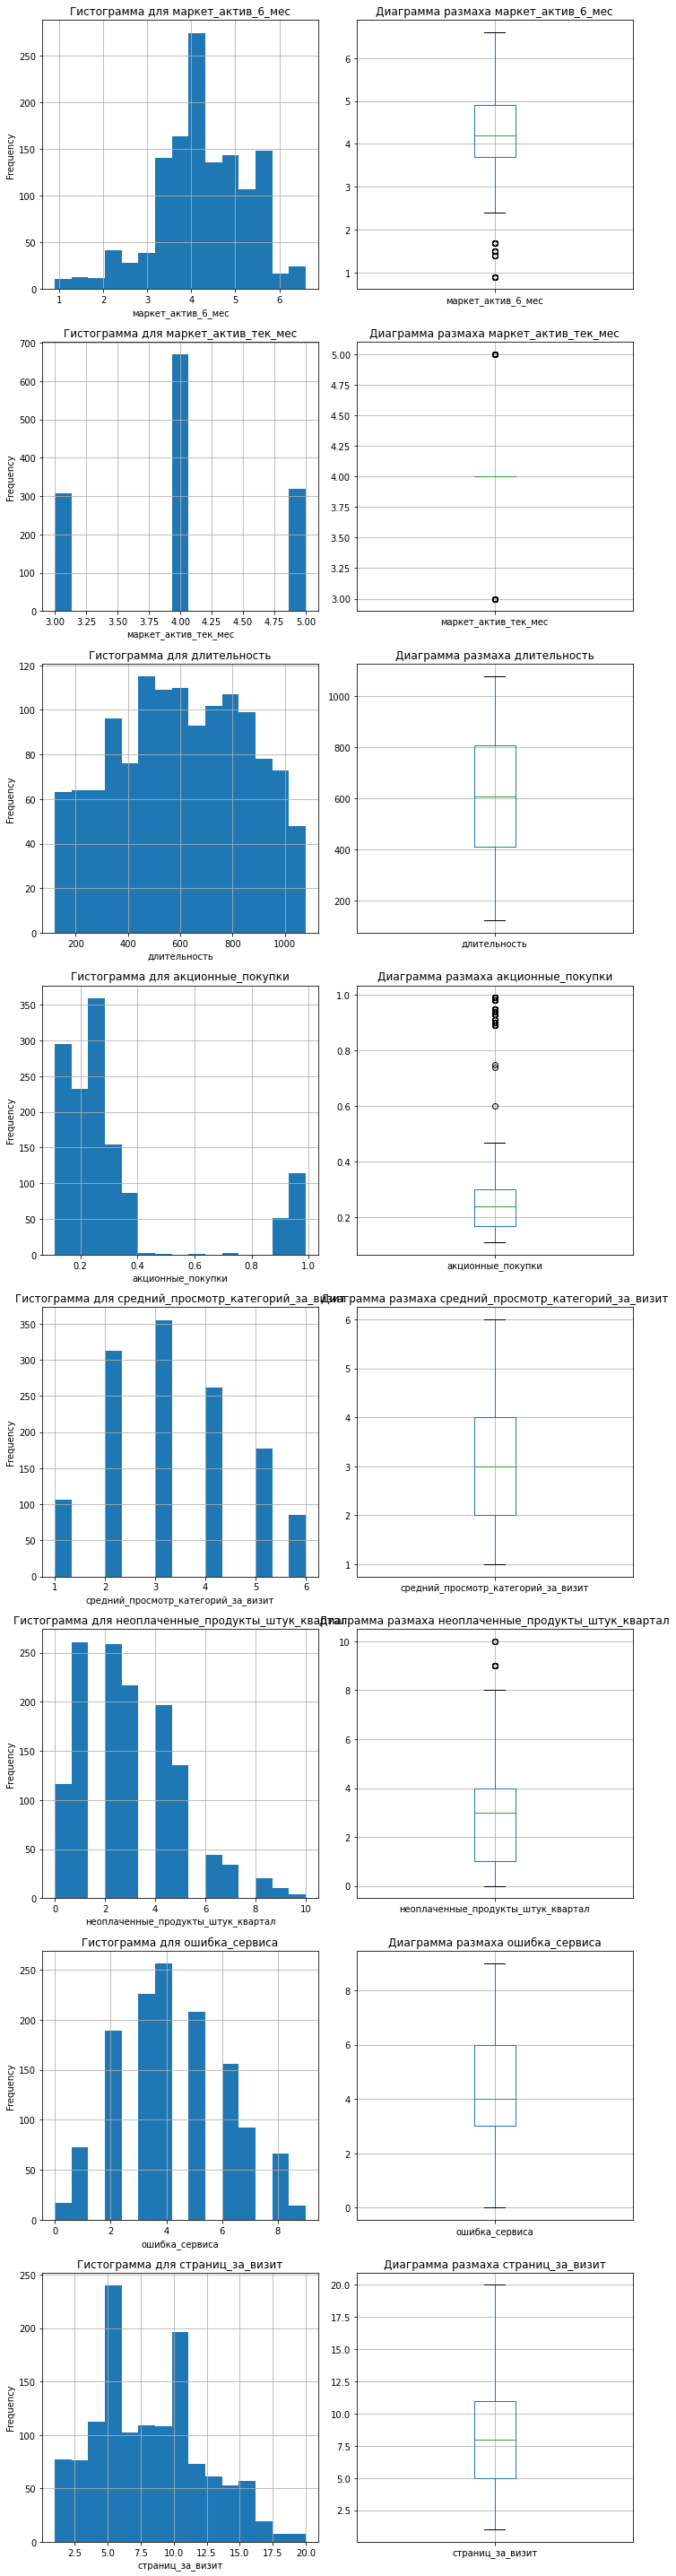

In [25]:
num_func(market_file)

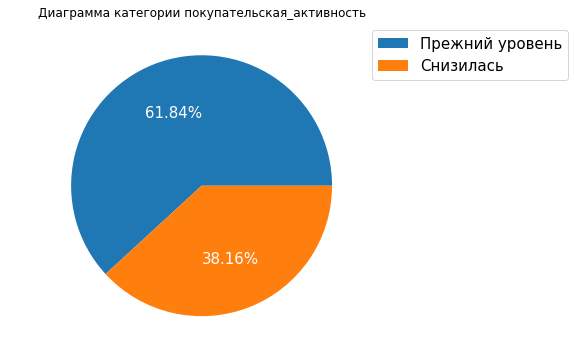

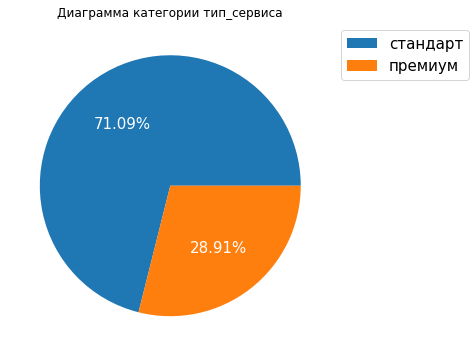

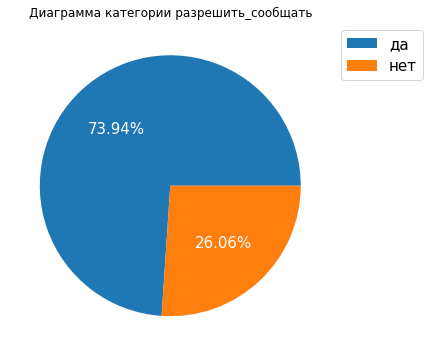

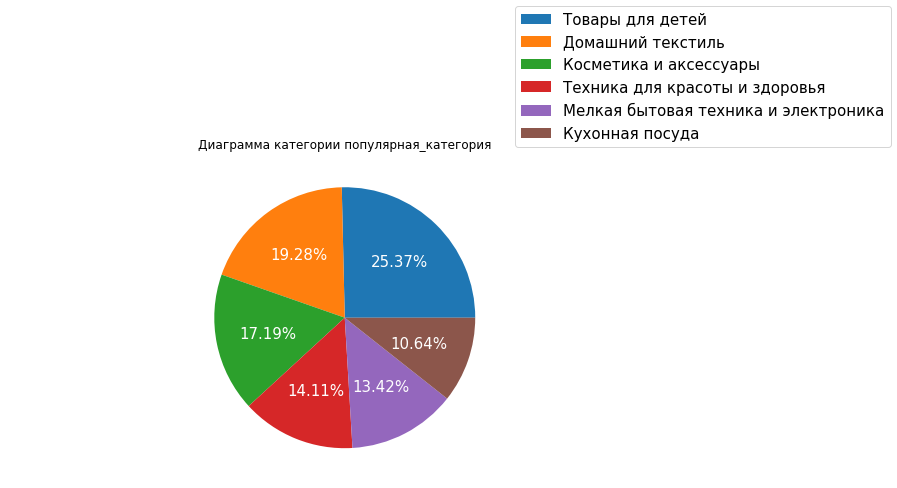

In [26]:
cat_func(market_file)

In [27]:
market_money.describe()

,выручка
count,3891.000000
mean,5033.718890
std,1768.471286
min,2758.700000
25%,4592.000000
50%,4959.000000
75%,5363.200000
max,106862.200000


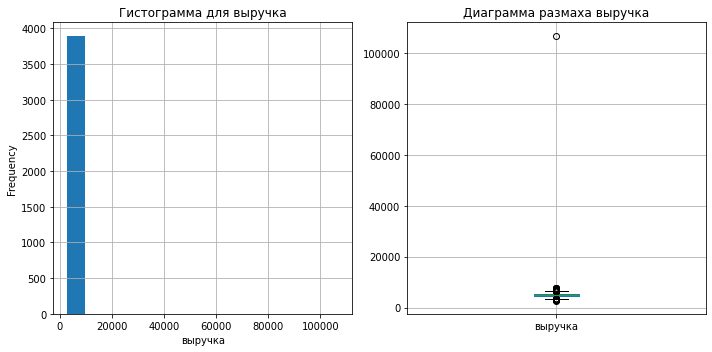

In [28]:
num_func(market_money)

Имеется выброс в столбце "выручка" Проверим это значение.

In [29]:
market_money[market_money['выручка'] > 20000]

,период,выручка
id,,
215380,текущий_месяц,106862.2


Одно это значение может помешать нам обучить модель. Удалим его.

In [30]:
market_money = market_money[market_money.index != 215380]

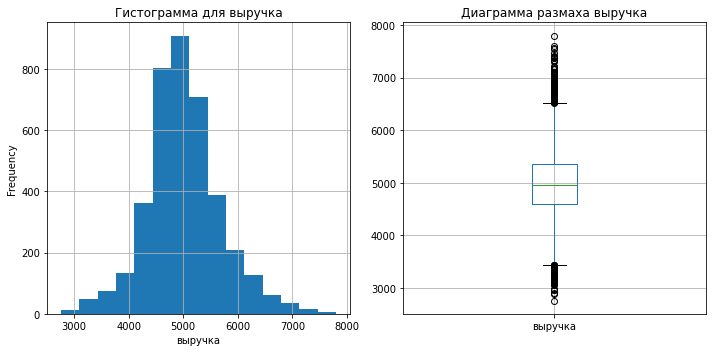

In [31]:
num_func(market_money)

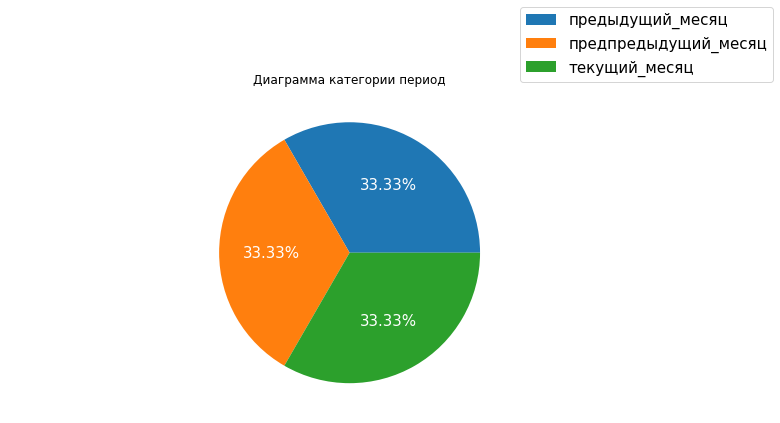

In [32]:
cat_func(market_money)

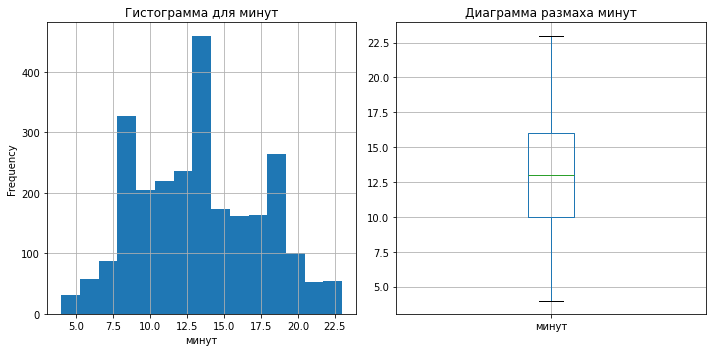

In [33]:
num_func(market_time)

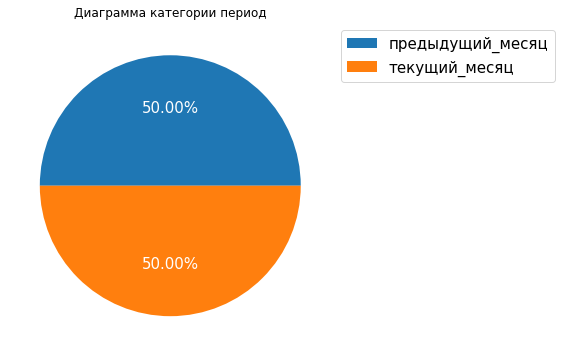

In [34]:
cat_func(market_time)

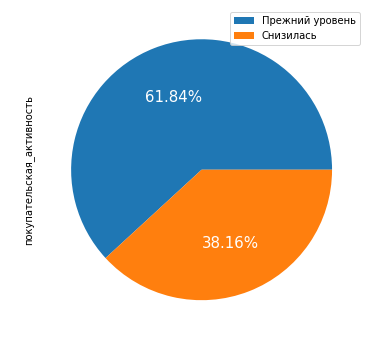

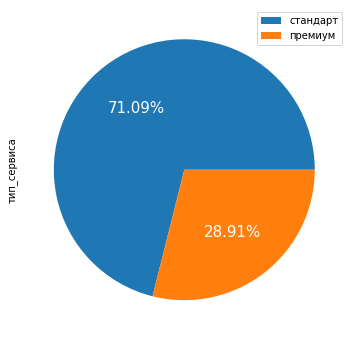

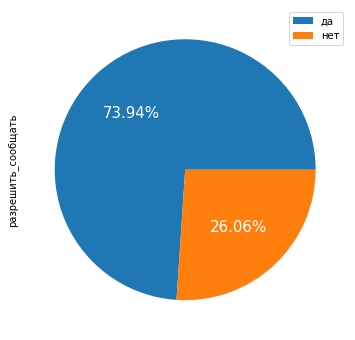

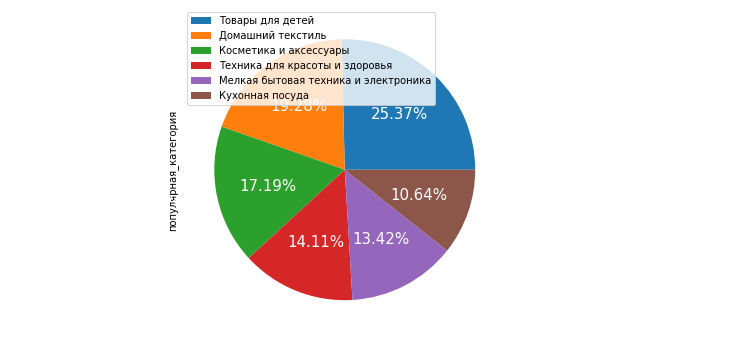

In [35]:
market_file_cat = market_file[market_file.select_dtypes(exclude='number').columns]
for i in market_file_cat.columns:
    market_file_cat[i].value_counts().plot(kind='pie', 
                             legend=True, 
                             autopct='%.2f%%', 
                             textprops={'color':'white', 'size':15}, 
                             figsize=(8, 6))
    plt.show()

<Axes: ylabel='покупательская_активность'>

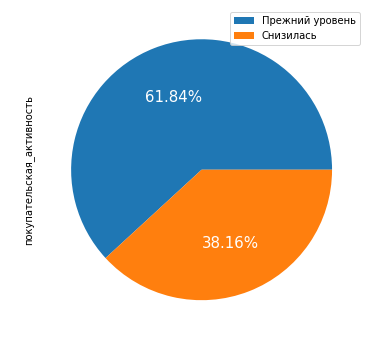

In [36]:
market_file_cat['покупательская_активность'].value_counts().plot(kind='pie', 
                             legend=True, 
                             autopct='%.2f%%', 
                             textprops={'color':'white', 'size':15}, 
                             figsize=(8, 6))

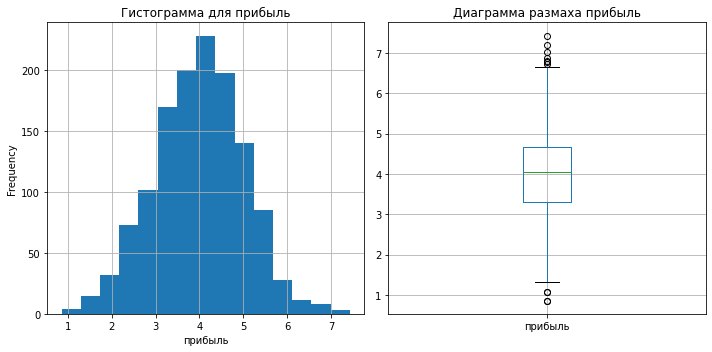

In [37]:
num_func(money)

__Вывод:__
- Мы отобрали активных пользователей, которые совершали покупки не менее 3 месяцев,
- Избавились от выброса в market_money.csv в признаке "выручка",
- Ненормальное распределение у маркет_актив_тек_мес из-за фиксированных значений (3,4,5), а также у акционных покупок. Может быть связанно с покупательской активностью во время проведений акций, соответственно произошло деление пользователей на 2 категории - у кого покупательская активность увеличена во время акции, а у кого уменьшена,
- У 62% пользователей осталась покупательская способность на том же уровне,
- 71% пользователей имеют тип сервиса стандарт,
- 74% пользователей дали согласие на получение дополнительного предложения о товаре,
- Категория Товары для детей - популярная категория на сайте;

<a id="4"></a> 
## Объединение таблиц

In [38]:
market_money.sort_values(by='выручка', ascending=False).head()

,период,выручка
id,,
215493,текущий_месяц,7799.4
215435,текущий_месяц,7605.3
215841,текущий_месяц,7557.0
216144,текущий_месяц,7547.8
215536,текущий_месяц,7467.9


Объеденим данные из датафреймов market_file, market_money, market_time в одну таблицу.

In [39]:
market_money

,период,выручка
id,,
215349,предпредыдущий_месяц,4472.0
215349,текущий_месяц,4971.6
215349,предыдущий_месяц,5216.0
215350,предпредыдущий_месяц,4826.0
215350,текущий_месяц,5058.4
...,...,...
216646,предпредыдущий_месяц,4725.0
216646,предыдущий_месяц,4923.0
216647,предыдущий_месяц,4720.0


In [40]:
market_money_pivot = market_money.pivot_table(index='id', values='выручка',\
                                              columns='период').add_prefix('выручка_')
market_money_pivot.index.name = None
market_money_pivot = market_money_pivot.rename_axis(None, axis=1)

In [41]:
market_time_pivot = market_time.pivot_table(index='id', values='минут',\
                                            columns='период').add_prefix('минут_')
market_time_pivot.index.name = None
market_time_pivot = market_time_pivot.rename_axis(None, axis=1)
market_time_pivot

,минут_предыдущий_месяц,минут_текущий_месяц
215349,12,10
215350,8,13
215351,11,13
215352,8,11
215353,10,10
...,...,...
216643,14,7
216644,12,11
216645,12,18
216646,18,7


In [42]:
market_db = market_file.join(market_time_pivot, how='inner' , on='id', lsuffix="_left", rsuffix="_выручка").join(market_money_pivot, on='id', how='inner', lsuffix="_left", rsuffix="_выручка")
market_db

,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,минут_предыдущий_месяц,минут_текущий_месяц,выручка_предпредыдущий_месяц,выручка_предыдущий_месяц,выручка_текущий_месяц
id,,,,,,,,,,,,,,,,,
215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,12,10,4472.0,5216.0,4971.6
215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,8,13,4826.0,5457.5,5058.4
215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,11,13,4793.0,6158.0,6610.4
215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,8,11,4594.0,5807.5,5872.5
215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,10,10,5124.0,4738.5,5388.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216643,Прежний уровень,стандарт,да,6.6,3,318,0.24,Техника для красоты и здоровья,5,3,3,11,14,7,4704.0,3664.0,4741.7
216644,Прежний уровень,стандарт,нет,5.1,4,454,0.21,Домашний текстиль,6,2,3,9,12,11,5299.0,4729.0,5353.0
216645,Прежний уровень,стандарт,да,4.1,3,586,0.20,Домашний текстиль,3,2,5,7,12,18,5334.0,5160.0,5139.2


In [43]:
market_db.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296 entries, 215349 to 216647
Data columns (total 17 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   покупательская_активность            1296 non-null   object 
 1   тип_сервиса                          1296 non-null   object 
 2   разрешить_сообщать                   1296 non-null   object 
 3   маркет_актив_6_мес                   1296 non-null   float64
 4   маркет_актив_тек_мес                 1296 non-null   int64  
 5   длительность                         1296 non-null   int64  
 6   акционные_покупки                    1296 non-null   float64
 7   популярная_категория                 1296 non-null   object 
 8   средний_просмотр_категорий_за_визит  1296 non-null   int64  
 9   неоплаченные_продукты_штук_квартал   1296 non-null   int64  
 10  ошибка_сервиса                       1296 non-null   int64  
 11  страниц_за_визит       

<a id="5"></a> 
## Корреляционный анализ

Т.к. у нас имеется неравномерное распределение, воспользуемся корреляцией Спирмана

Преобразуем целевой категориальный признак покупательская_активность в бинарный

In [44]:
market_db_corr = market_db.copy()
# перезапишем столбец 'покупательская_активность' с помощью функции to_binary_func
market_db_corr["покупательская_активность"] = (
    market_db_corr["покупательская_активность"]
    .str.replace("Снизилась", "0", regex=False)
    .str.replace("Прежний уровень", "1", regex=False)
    .astype('int')
)

In [45]:
market_db.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296 entries, 215349 to 216647
Data columns (total 17 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   покупательская_активность            1296 non-null   object 
 1   тип_сервиса                          1296 non-null   object 
 2   разрешить_сообщать                   1296 non-null   object 
 3   маркет_актив_6_мес                   1296 non-null   float64
 4   маркет_актив_тек_мес                 1296 non-null   int64  
 5   длительность                         1296 non-null   int64  
 6   акционные_покупки                    1296 non-null   float64
 7   популярная_категория                 1296 non-null   object 
 8   средний_просмотр_категорий_за_визит  1296 non-null   int64  
 9   неоплаченные_продукты_штук_квартал   1296 non-null   int64  
 10  ошибка_сервиса                       1296 non-null   int64  
 11  страниц_за_визит       

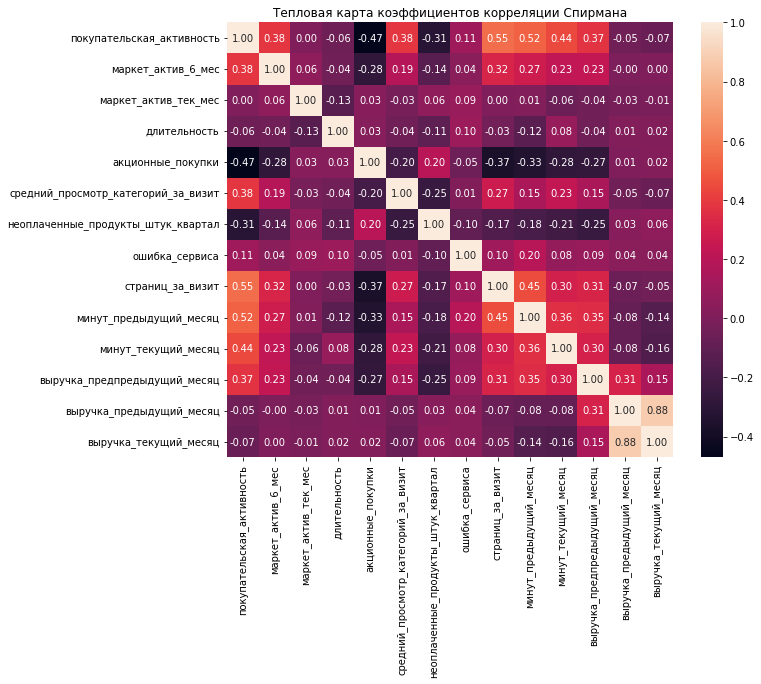

In [46]:
plt.figure(figsize=(10, 8))
sns.heatmap(market_db_corr.select_dtypes(include=np.number).corr(method='spearman'), annot=True, fmt='.2f')
plt.title('Тепловая карта коэффициентов корреляции Спирмана');

Вывод: 
- Целевой признак - Покупательская_активность
- Корреляция с целевым признаком имеют признаки:
        Маркет_актив_6_мес, Акционные_покупки, Средний_просмотр_категорий_за_визит, Неоплаченные_продукты_штук_квартал, Страниц_за_визит, Выручка_препредыдущий_месяц, минут_предыдущий_месяц, минут_текущий_месяц.

<a id="6"></a> 
## Создание пайплайна

Приступим к непосредственному построению модели. Мы переберем модели KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression() и SVC().

In [47]:
X = market_db.drop(['покупательская_активность'], axis=1)
y = market_db['покупательская_активность']

In [48]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = 0.25, 
    random_state = RANDOM_STATE,
    stratify = y)
market_db.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296 entries, 215349 to 216647
Data columns (total 17 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   покупательская_активность            1296 non-null   object 
 1   тип_сервиса                          1296 non-null   object 
 2   разрешить_сообщать                   1296 non-null   object 
 3   маркет_актив_6_мес                   1296 non-null   float64
 4   маркет_актив_тек_мес                 1296 non-null   int64  
 5   длительность                         1296 non-null   int64  
 6   акционные_покупки                    1296 non-null   float64
 7   популярная_категория                 1296 non-null   object 
 8   средний_просмотр_категорий_за_визит  1296 non-null   int64  
 9   неоплаченные_продукты_штук_квартал   1296 non-null   int64  
 10  ошибка_сервиса                       1296 non-null   int64  
 11  страниц_за_визит       

Закодируем целевой признак

In [49]:
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test) 

In [50]:
ohe_columns = ['популярная_категория',]
ord_columns = ['тип_сервиса','разрешить_сообщать']
num_columns = ['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
               'средний_просмотр_категорий_за_визит','акционные_покупки',
               'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
               'страниц_за_визит', 'минут_предыдущий_месяц', 'минут_текущий_месяц', 
               'выручка_предпредыдущий_месяц', 'выручка_предыдущий_месяц', 'выручка_текущий_месяц']

In [51]:
ohe_pipe = Pipeline(
    [
        ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ohe', OneHotEncoder(drop='first',handle_unknown='error', sparse_output=False))
    ]
)

In [52]:
ord_pipe = Pipeline(
    [
        ('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ord',  OrdinalEncoder(categories=[
            ['стандарт', 'премиум'], 
            ['нет','да']],
                                handle_unknown='use_encoded_value', unknown_value=np.nan
                               )
        ),
        ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

In [53]:
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

In [54]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

In [55]:
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 7),
        'models__max_features': range(2, 7),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    # словарь для модели SCV()
    {
        'models': [SVC(random_state=RANDOM_STATE, kernel='poly',probability= True)],
        'models__degree': range(2, 6),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    } 
]

У нас небольшие диапазоны значений но с учетом числа моделей перебирать будет долго. Выбираем рандомизированный поиск RandomizedSearchCV

In [56]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

In [57]:
randomized_search.fit(X_train, y_train);

In [58]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print(f'Параметры лучшей модели:\n{randomized_search.best_params_}')
print ('Метрика лучшей модели на тренировочной выборке:', round(randomized_search.best_score_, 3))

y_pred = randomized_search.predict_proba(X_test)[:,1]
print(f'Метрика ROC-AUC на тестовой выборке: {round(roc_auc_score(y_test, y_pred), 3)}')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False))]),
                                                  ['популярная_категория']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent')),
        

In [59]:
y_pred = randomized_search.predict(X_test)
print(f'Метрика F1-score на тестовой выборке: {round(f1_score(y_test, y_pred, average="binary"), 2)}')

Метрика F1-score на тестовой выборке: 0.87


__Вывод:__ На данном шаге исследования была найдена и обучена модель для определения снижения активности покупателей сервиса. Лучшие результаты показала модель LogisticRegression(C=1, penalty='l1', random_state=42, solver='liblinear'). Метрика roc_auc для тренировочной выборки показла результат 0.898, для тестовой выборки 0.889. Модель справляется с предсказанием. Метрика f1 - 0.87.

<a id="7"></a> 
## Анализ важности признаков

Оценим важность признаков для лучшей модели и построим график важности с помощью метода SHAP.

Обучаем лучшую модель и строим

In [60]:
# объявляем классификатор и обучаем модель
X_train_shap = pipe_final.named_steps['preprocessor'].fit_transform(X_train)
X_test_shap = pipe_final.named_steps['preprocessor'].transform(X_test)


feature_names = pipe_final.named_steps['preprocessor'].get_feature_names_out()
X_test_shap = pd.DataFrame(X_test_shap, columns=feature_names)

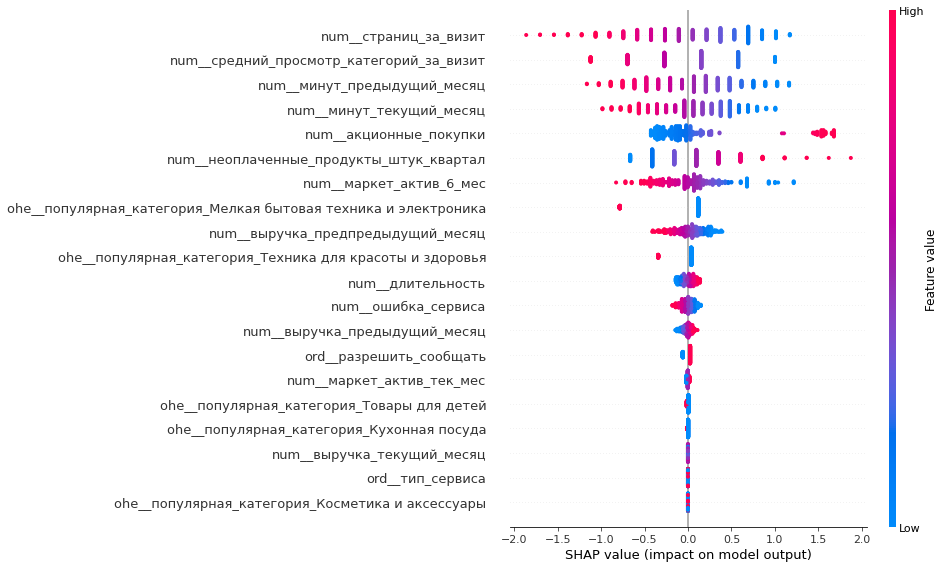

In [61]:
# строим график beeswarm для лучшей модели
explainer = shap.Explainer(randomized_search.best_estimator_.named_steps['models'], X_train_shap)
shap_values = explainer(X_test_shap)
shap.plots.beeswarm(shap_values, max_display=21)

__Вывод:__ 
- Пять самых важных для модели признаков: 
    - Страниц_за_визит,
    - Средний_просмотр_категорий_за_визит, 
    - минут_предыдущий_месяц, 
    - акционные_покупки, 
    - минут_текущий_месяц.
- Малозначимыми признаками :
    - Популярная категория(кроме бытовой техники), 
    - Выручка,
    - Ошибка_сервиса,
    - Длительность,  
    - Разрешить сообщать, 
    - Маркет_актив_тек_мес, 
    - Тип_сервиса, 

При акционных покупках у нас возрастает вероятность что у пользователя снизиться покупательская активность. Это может быть связано, что большая часть пользователей при появлении акции, начинают активно закупать популярными категориями по скидке, а после уходят с площадки в ожидании новых акций

Рекомендации бизнесу:
- на покупателей оказывает влияние наличие акционных предложений, возможно объём таких предложений стоит расширить. 
- чем дольше покупатель находится на сайте и чем больше просматривает страниц, тем выше вероятность, что он совершит покупку и покупательская активность останеться на прежнем уровне. Возможно стоит увеличить ассортимент категорий, чтобы завлечь пользователя остаться дольше на сайте.


<a id="8"></a> 
## Сегментация пользователей

Сегментируем пользователей по группе.

Выбранный сегмент:
- Покупателей с высокой прибыльностью (>4)
- и высокой вероятностью снижения покупательской активности (>0.7)


In [62]:
y_test_proba = randomized_search.predict_proba(X_test)[:,1]
y_train_proba = randomized_search.predict_proba(X_train)[:,1]

In [63]:
X_test_full = X_test.copy()
X_train_full = X_train.copy()
X_test_full['вероятность_снижения'] = y_test_proba
X_train_full['вероятность_снижения'] = y_train_proba
market_db = pd.concat([X_train_full, X_test_full])

df_full = market_db.join(money)

In [64]:
seg_1 = df_full.query('вероятность_снижения >= 0.7 and прибыль > 4')
merged = df_full.query('вероятность_снижения < 0.7 and прибыль > 4')
merged

,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,минут_предыдущий_месяц,минут_текущий_месяц,выручка_предпредыдущий_месяц,выручка_предыдущий_месяц,выручка_текущий_месяц,вероятность_снижения,прибыль
id,,,,,,,,,,,,,,,,,,
215858,стандарт,да,5.5,4,510,0.15,Мелкая бытовая техника и электроника,2,4,7,16,20,6,4347.0,5170.5,6014.2,0.068141,4.37
215361,стандарт,да,5.1,4,199,0.23,Техника для красоты и здоровья,4,5,2,3,11,13,4597.0,6400.0,3789.7,0.563651,4.03
215884,стандарт,да,4.3,5,997,0.17,Мелкая бытовая техника и электроника,5,1,3,11,13,10,4626.0,4113.0,3798.4,0.060044,4.37
216533,стандарт,нет,5.7,5,769,0.14,Техника для красоты и здоровья,4,1,8,10,15,20,4925.0,5868.0,5180.3,0.019538,6.59
216334,премиум,да,6.1,3,1056,0.17,Домашний текстиль,2,3,7,8,15,17,5315.0,4767.5,4423.0,0.150906,4.84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216232,стандарт,нет,5.5,4,582,0.21,Косметика и аксесcуары,5,1,5,6,11,19,4592.0,4071.5,3750.4,0.088171,4.94
216370,стандарт,нет,5.2,4,717,0.13,Кухонная посуда,2,3,5,9,15,10,5035.0,5767.0,6531.4,0.306463,4.12
216646,стандарт,да,6.3,5,645,0.12,Техника для красоты и здоровья,3,3,5,7,18,7,4725.0,4923.0,5224.6,0.165426,4.03


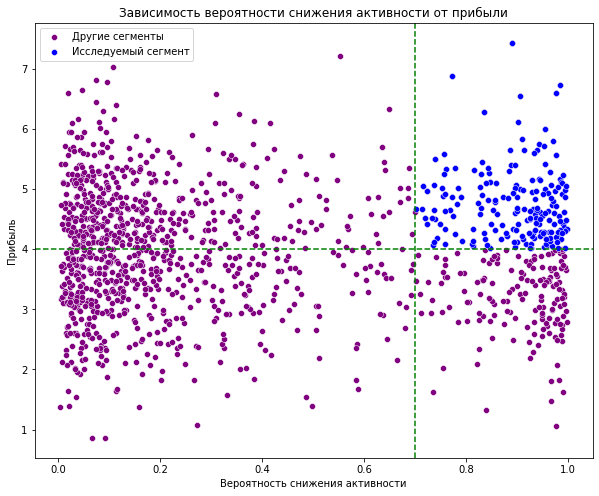

In [65]:
fig = plt.figure(figsize=(10,8))
sns.scatterplot(data=df_full,x='вероятность_снижения', y='прибыль', label='Другие сегменты', color='purple')
sns.scatterplot(data=seg_1,x='вероятность_снижения', y='прибыль',label='Исследуемый сегмент', color='blue')
plt.xlabel('Вероятность снижения активности')
plt.ylabel('Прибыль')
plt.axvline(x=0.7, color='green', linestyle='--')
plt.axhline(y=4, color='green', linestyle='--')
plt.title('Зависимость вероятности снижения активности от прибыли')
plt.show()

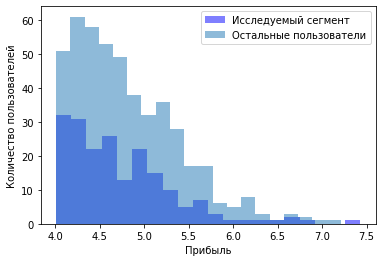

In [66]:
plt.hist(seg_1['прибыль'], bins=20, color='blue', alpha=0.5, label='Исследуемый сегмент')
plt.hist(merged['прибыль'], bins=20, alpha=0.5, label='Остальные пользователи')
plt.xlabel('Прибыль')
plt.ylabel('Количество пользователей')
plt.legend(loc='upper right')
plt.show()

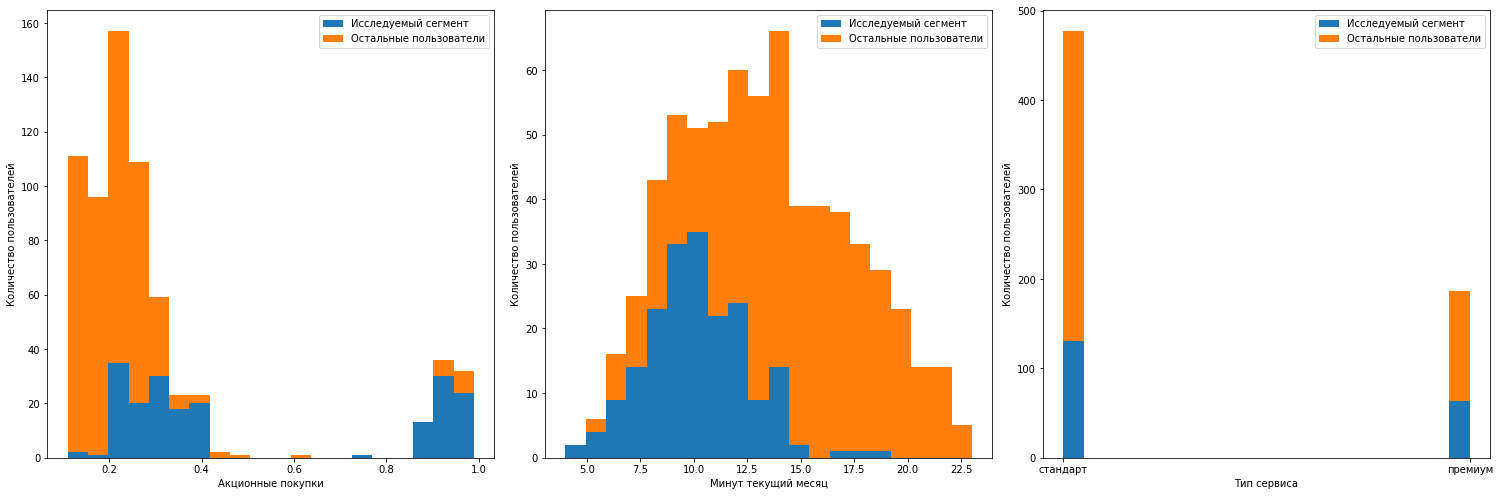

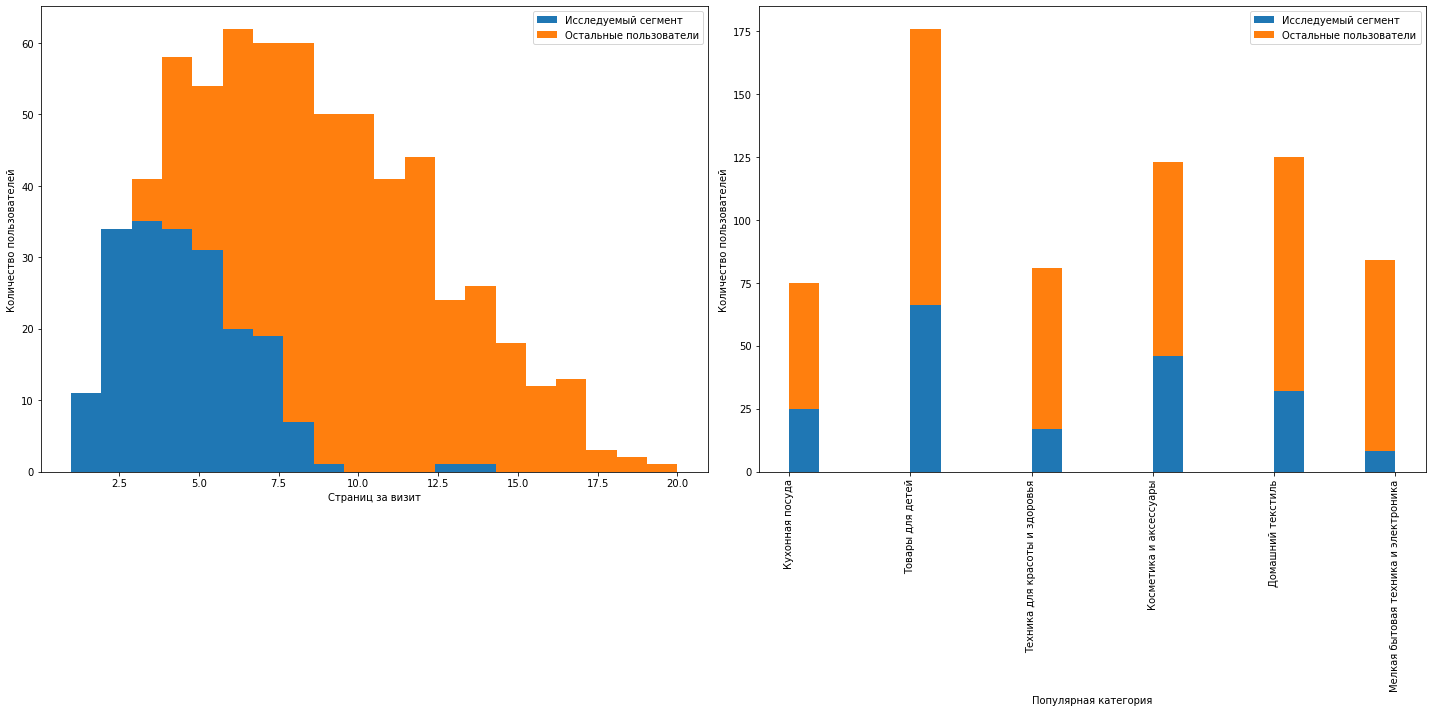

In [67]:
plt.figure(figsize=(21, 7))

plt.subplot(1, 3, 1)
plt.hist(
    [seg_1['акционные_покупки'],merged['акционные_покупки']], 
    bins=20, 
    stacked=True, 
    label=['Исследуемый сегмент', 'Остальные пользователи']
)

plt.xlabel('Акционные покупки')
plt.ylabel('Количество пользователей')
plt.legend(loc='upper right')

plt.subplot(1, 3, 2)
plt.hist(
    [seg_1['минут_текущий_месяц'],merged['минут_текущий_месяц']], 
    bins=20, 
    stacked=True, 
    label=['Исследуемый сегмент', 'Остальные пользователи']
)

plt.xlabel('Минут текущий месяц')
plt.ylabel('Количество пользователей')
plt.legend(loc='upper right')

plt.subplot(1, 3, 3)
plt.hist(
    [seg_1['тип_сервиса'],merged['тип_сервиса']], 
    bins=20, 
    stacked=True, 
    label=['Исследуемый сегмент', 'Остальные пользователи']
)
plt.xlabel('Тип сервиса')
plt.ylabel('Количество пользователей')
plt.legend(loc='upper right')



plt.tight_layout()
plt.show()

plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.hist(
    [seg_1['страниц_за_визит'],merged['страниц_за_визит']], 
    bins=20, 
    stacked=True, 
    label=['Исследуемый сегмент', 'Остальные пользователи']
)
plt.xlabel('Страниц за визит')
plt.ylabel('Количество пользователей')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.hist(
    [seg_1['популярная_категория'],merged['популярная_категория']], 
    bins=20, 
    stacked=True, 
    label=['Исследуемый сегмент', 'Остальные пользователи']
)
plt.xlabel('Популярная категория')
plt.ylabel('Количество пользователей')
plt.legend(loc='upper right')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

__Вывод:__ Выбрали сегмент для анализа: Выбранный сегмент:

- Покупатели с высокой прибыльностью (>4)
- Высокая вероятность снижения покупательской активности (>0.7)

У 194 пользователей высокая вероятность снижения покупательской активности, которая в основном учавствует в акциях и покупает товары для детей. Такие пользователи не упустят выгодные скидки и условия, чтобы купить дешевле. не сидят долго на сайте, смотрят по своей выбранной катеогрии, а после уходят с сайта. Возможно что дальше по страницам отсутсвуют товары по акции, и пользователи просто уходят.

Рекомендация бизнесу:
- Можно увеличить предлагаемую информацию о товаре пользователю, если по категории Товары для детей проходит акция. Также можно предложить акции по другим категориям, которые учавствуют в распродажах.
- Увеличить ассортимент товаров по другим категориям. 
- Не тратить средства на рассылки таким пользователям, только во время крупных распродаж или акций.
- Предложить более выгодные условия при переходе на премиум, чтобы удержать не только на определенной категории, но и привлеч другие.

<a id="9"></a> 
## Общий вывод

__Описание задачи__

Целью исследования было:
1. Построить модель для предсказания снижения покупательской активности.
2. Выделить сегмент покупателей и разработать персонализированные предложения для увеличения их покупательской активности.

__Исходные данные и предобработка__

Исходные данные включали четыре таблицы:
1. **market_file.csv**: данные о поведении покупателя на сайте, коммуникации и продуктовом поведении.
2. **market_money.csv**: данные о выручке магазина от покупателя за период.
3. **market_time.csv**: данные о времени, которое покупатель провёл на сайте.
4. **money.csv**: данные о среднемесячной прибыли покупателя за последние 3 месяца.

Предобработка данных включала:
- Проверку на наличие пропусков, тип данных и дубликаты.
- Стандартизацию имен признаков и приведение типов данных.
- Устранение неявных дубликатов и опечаток.
- Объединение таблиц в единый датафрейм для моделирования.

__Поиск лучшей модели__

Для поиска лучшей модели:
1. Провели корреляционный анализ признаков с целевым.
2. Разделили данные на тренировочные и тестовые выборки с учетом стратификации.
3. Создали пайплайн с моделями:
    - DecisionTreeClassifier
    - KNeighborsClassifier
    - LogisticRegression
    - SVC

__Подбор гиперпараметров:__
- **DecisionTreeClassifier**: max_depth от 2 до 7, max_features от 2 до 7.
- **KNeighborsClassifier**: n_neighbors от 2 до 10.
- **LogisticRegression**: solver='liblinear', C от 1 до 5.
- **SVC**: kernel='linear', сила модели от 2 до 6.

Оценка эффективности моделей проводилась по метрике ROC-AUC.

__Лучшая модель__

Лучшей моделью стала **LogisticRegression(C=1, penalty='l1', random_state=42, solver='liblinear'))** со скалером MinMaxScaler:
- ROC-AUC на тренировочной выборке: 0.898
- ROC-AUC на тестовой выборке: 0.889

__Выводы и предложения для выбранного сегмента покупателей__

Выбранный сегмент для анализа:

- Высокая доля покупок по акции (>0.8)
- Высокая вероятность снижения покупательской активности (>0.7)

У 128 пользователей высокая вероятность снижения покупательской активности, при этом они в основном участвуют в акциях и покупают товары для детей. Такие пользователи активно ищут выгодные скидки и условия для покупки товаров дешевле. Обычно они просматривают до 4 страниц сайта, фокусируясь на своей выбранной категории, после чего покидают сайт.

Рекомендации бизнесу:

1. **Увеличение информации о товарах**: Увеличить предлагаемую информацию о товаре для пользователей, если по категории "Товары для детей" проходит акция. Также можно предложить акции по другим категориям.
2. **Расширение ассортимента**: Увеличить ассортимент товаров в других категориях, чтобы привлечь внимание пользователей к более широкому спектру продуктов.
3. **Ограничение рассылок**: Не тратить средства на рассылки таким пользователям, за исключением крупных распродаж или акций.
4. **Выгодные условия для премиум-обслуживания**: Предложить более выгодные условия при переходе на премиум, чтобы удержать пользователей не только на определенной категории, но и привлечь их к другим категориям товаров.